In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
# from pylab import rcParams

import tensorflow as tf
# import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

# from tensorflow.keras import Sequential, Input
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

# from numpy.random import seed
# seed(7)
tf.random.set_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123   # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

# rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
import os
import csv

# path_1 : 정상 데이터
# path_2 : 고장 데이터

# lab pc file dir
# path_1 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DEF-01/정상/"
# path_2 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DSF-01/축정렬불량/"

# home pc file dir
path_1 = "G:/VSC/MLD/DB/정상/"
path_2 = "G:/VSC/MLD/DB/축정렬불량/"

# sample
# file_list_1 = os.listdir(path_1)[:10]
# file_list_2 = os.listdir(path_2)[:10]

# main (Full Training)
file_list_1 = os.listdir(path_1)[:]
file_list_2 = os.listdir(path_2)[:]

file_list = file_list_1 + file_list_2

In [3]:
# 파일로 부터 원하는 정보 추출

raw_data = []

for i, file_name in enumerate(file_list):
    if i < len(file_list_1):
        f = open(path_1+file_name, 'r', encoding='utf-8')
    else:
        f = open(path_2+file_name, 'r', encoding='utf-8')

    # rdr : file to list
    rdr = list(csv.reader(f))

    label = int(rdr[3][1]) # y
    # period = rdr[5][1]
    # rate = rdr[6][1]
    # RMS_value = rdr[7][1]
    # length = rdr[8][1]

    value = np.array(list(rdr[9:]))[:, 1:2] # X

    f.close()

    # data = [value, label, period, rate, RMS_value, length]
    data = [value, label]
    raw_data.append(data)

In [4]:
# samples
print(np.array(raw_data)[:3])

[[array([['0.0005438852'],
         ['0.0017023650'],
         ['0.0065568085'],
         ...,
         ['-0.0024770722'],
         ['-0.0016325777'],
         ['-0.0003203535']], dtype='<U13') 0]
 [array([['-0.0048005437'],
         ['-0.0043715788'],
         ['-0.0014246076'],
         ...,
         ['-0.0015328046'],
         ['-0.0017771638'],
         ['-0.0033223764']], dtype='<U13') 0]
 [array([['-0.0042272401'],
         ['-0.0026620959'],
         ['-0.0011944623'],
         ...,
         ['-0.0027607153'],
         ['-0.0035820075'],
         ['-0.0021456955']], dtype='<U13') 0]]


C:\Users\qwt15\AppData\Local\Temp\ipykernel_22392\3138304901.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(raw_data)[:3])


In [5]:
# 정보로 부터 학습에 사용할 벡터 생성

column_name = ['y', 'x']
temporalize_df = []

for d in raw_data:
    if d[1] == 0:
        temp = np.concatenate((np.zeros((12000, 1)), d[0]), axis=1)
    else:
        temp = np.concatenate((np.ones((12000, 1)), d[0]), axis=1)
        
    temporalize_df.append(pd.DataFrame(temp, columns=column_name).astype(np.float32))

In [6]:
# samples
print(temporalize_df[:1])

[         y         x
0      0.0  0.000544
1      0.0  0.001702
2      0.0  0.006557
3      0.0  0.006219
4      0.0  0.000708
...    ...       ...
11995  0.0  0.000625
11996  0.0 -0.001753
11997  0.0 -0.002477
11998  0.0 -0.001633
11999  0.0 -0.000320

[12000 rows x 2 columns]]


In [7]:
# 시계열 데이터를 원하는 크기로 조각냄

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(0, len(X)-lookback-1, lookback//2):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [8]:
# 8개를 한 주기로 조각냄
# 12000개의 시계열 데이터에서 최대 12000 - 7 개의 조각이 나오지만
# 데이터가 너무 많아지면 학습에 사용할 컴퓨터의 성능 제약 때문에
# 주기의 절반만큼 건너뛰게 하여 (12000//4)-(8//2) = 2998 개의 조각이 나오도록 함.

n_features = 1
lookback = 8

X = []
y = []

for d in temporalize_df:
    input_X = d.loc[:, d.columns != 'y'].values
    input_y = d['y'].values

    nX, ny = temporalize(X = input_X, y = input_y, lookback = lookback)
    X.extend(nX)
    y.extend(ny)

In [9]:
# 성능 검증 밑 과적합 방지를 위해 train valid test 분리 (약 6:2:2)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [10]:
# y=0 인 정상 데이터만 학습에 활용하므로 분리

X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [11]:
print(len(X_train_y0))
print(len(X_train_y1))
print(len(X_valid_y0))
print(len(X_valid_y1))

19224
19150
4718
4876


In [12]:
# 학습에 사용하기 위해 원하는 모양으로 가공

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [13]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [14]:
scaler = StandardScaler().fit(flatten(X_train_y0))

In [15]:
# 학습의 효율 증대를 위해 scaler 사용

X_train_y0_scaled = scale(X_train_y0, scaler).astype(np.float32)
X_train_y1_scaled = scale(X_train_y1, scaler).astype(np.float32)
X_train_scaled = scale(X_train, scaler).astype(np.float32)

In [16]:
# scale이 잘 진행 되었는지 확인
# 평균 0 분산 1이 나오면 정상

a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.]
colwise variance [1.]


In [17]:
X_valid_scaled = scale(X_valid, scaler).astype(np.float32)
X_valid_y0_scaled = scale(X_valid_y0, scaler).astype(np.float32)
X_test_scaled = scale(X_test, scaler).astype(np.float32)

In [18]:
# parameters

timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 60
batch = 4096
lr = 0.0001

In [19]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 8, 16)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 8, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 8, 32)             6272      
                                                                 
 time_distributed (TimeDistr  (None, 8, 1)             33        
 ibuted)                                                

In [20]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [21]:
# tf.debugging.set_log_device_placement(True)

In [22]:
lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                # callbacks=[es, mc, rlr, csvlogger],
                                                verbose=2).history

Epoch 1/60
5/5 - 6s - loss: 1.0123 - val_loss: 1.0134 - 6s/epoch - 1s/step
Epoch 2/60
5/5 - 1s - loss: 1.0109 - val_loss: 1.0120 - 866ms/epoch - 173ms/step
Epoch 3/60
5/5 - 1s - loss: 1.0096 - val_loss: 1.0107 - 837ms/epoch - 167ms/step
Epoch 4/60
5/5 - 1s - loss: 1.0083 - val_loss: 1.0095 - 862ms/epoch - 172ms/step
Epoch 5/60
5/5 - 1s - loss: 1.0071 - val_loss: 1.0083 - 858ms/epoch - 172ms/step
Epoch 6/60
5/5 - 1s - loss: 1.0059 - val_loss: 1.0071 - 858ms/epoch - 172ms/step
Epoch 7/60
5/5 - 1s - loss: 1.0048 - val_loss: 1.0059 - 829ms/epoch - 166ms/step
Epoch 8/60
5/5 - 1s - loss: 1.0036 - val_loss: 1.0047 - 819ms/epoch - 164ms/step
Epoch 9/60
5/5 - 1s - loss: 1.0024 - val_loss: 1.0034 - 820ms/epoch - 164ms/step
Epoch 10/60
5/5 - 1s - loss: 1.0011 - val_loss: 1.0021 - 811ms/epoch - 162ms/step
Epoch 11/60
5/5 - 1s - loss: 0.9998 - val_loss: 1.0007 - 814ms/epoch - 163ms/step
Epoch 12/60
5/5 - 1s - loss: 0.9984 - val_loss: 0.9992 - 853ms/epoch - 171ms/step
Epoch 13/60
5/5 - 1s - loss: 0.

In [23]:
# import pickle
# import joblib

In [24]:
# model 저장

lstm_autoencoder.save("lstm_autoencoder.h5")

In [25]:
# model 불러오기

# lstm_autoencoder = keras.models.load_model("1123_model.h5")

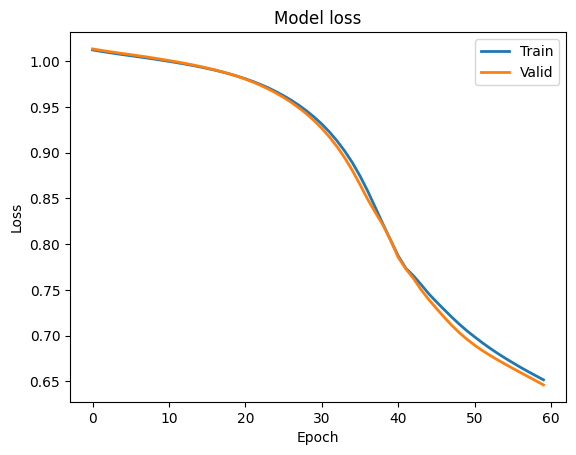

In [26]:
# training loss graph

plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [27]:
################################################################################################
### 이후 나오는 자료들은 학습할 때 참고용으로만 사용했습니다.                                    ###
### 모델의 예측 결과로 부터 전동기의 고장여부를 판단하는 내용은 Prediction.ipynb 에 있습니다.     ###
################################################################################################


1200/1200 [==============================] - 17s 14ms/step


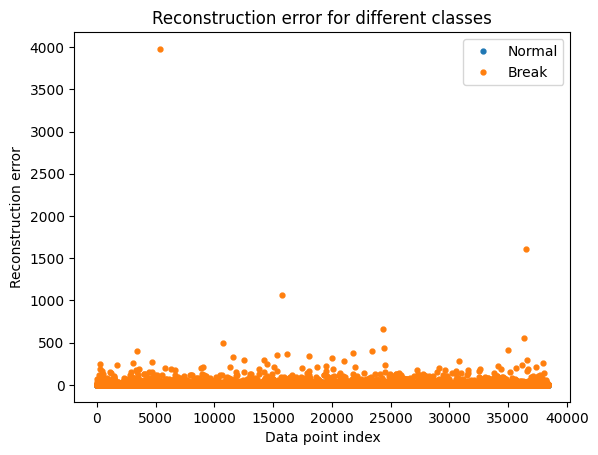

In [28]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

300/300 [==============================] - 6s 20ms/step


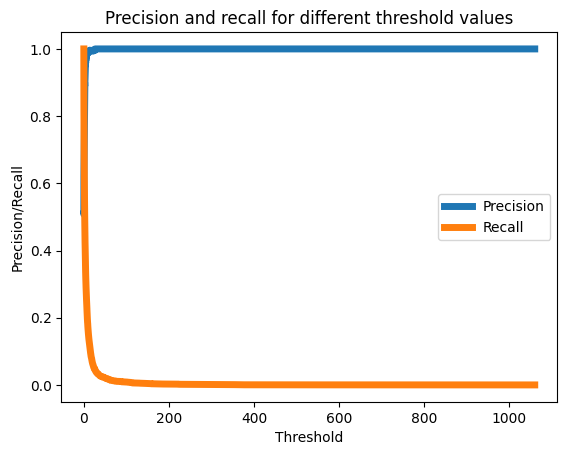

In [30]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# 임계값이 0.25~0.75 사이에서 성능이 잘 나오는데
# 그래프가 0부터 1000까지 보여주어 확인이 힘듭니다.

375/375 [==============================] - 6s 15ms/step


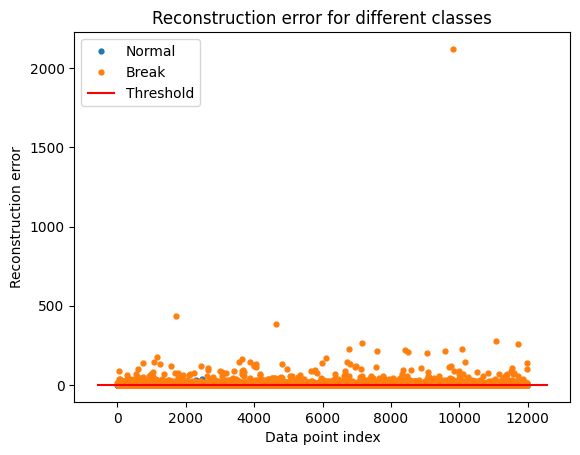

In [31]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [32]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

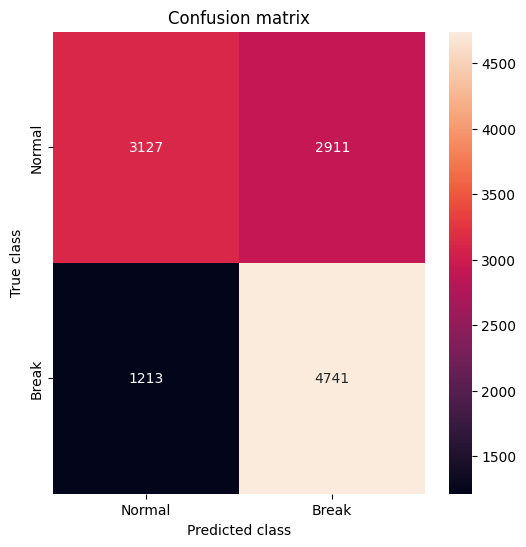

In [33]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

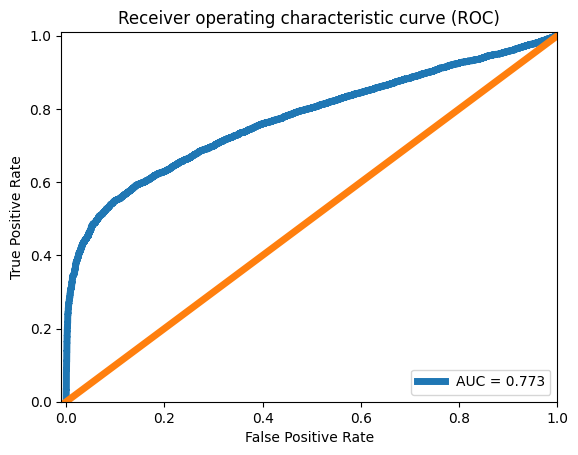

In [34]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()